In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from skimage.morphology import closing, square
from plot import plot_two_figures, plot_confusion_matrix, plot_each_labels, plot_histogram_compare_predict_expect
from tools import get_number_components, extract_features, remove_unclassified_input, shuffle, split_x_train_test, calculate_mean_score

# Loading data & Pre-processing

Loading Indiana and Salinas images and their ground truth

In [2]:
indiana_img = np.load('../data/indianapines.npy')
indiana_labels = np.load('../data/indianapines_gt.npy')
salinas_img = np.load('../data/salinas.npy')
salinas_labels = np.load('../data/salinas_gt.npy')

In [3]:
# normalize radiance values to get reflectance values
indiana_img = indiana_img / indiana_img.max()
salinas_img = salinas_img / salinas_img.max()

In [4]:
print("Indiana shape: {}".format(indiana_img.shape))
print("Salinas shape: {}".format(salinas_img.shape))

Indiana shape: (145, 145, 200)
Salinas shape: (512, 217, 204)


In [5]:
X_indiana = indiana_img.reshape((-1, indiana_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Indiana shape: {}".format(X_indiana.shape))

X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Salinas shape: {}".format(X_salinas.shape))

Indiana shape: (21025, 200)
Salinas shape: (111104, 204)


In [6]:
n_classes_indiana = len(np.unique(indiana_labels)) - 1
n_classes_salinas = len(np.unique(salinas_labels)) - 1

In [7]:
print("Number of labels Indiana: {}".format(n_classes_indiana))
print("Number of labels Salinas: {}".format(n_classes_salinas))

Number of labels Indiana: 16
Number of labels Salinas: 16


In [8]:
indiana_class_names = np.arange(n_classes_indiana).astype(str)
salinas_class_names = np.arange(n_classes_salinas).astype(str)

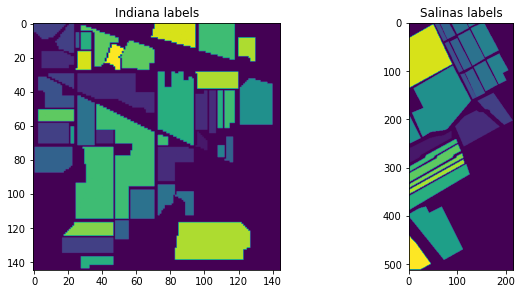

In [9]:
# Display ground truth for each image
plot_two_figures(indiana_labels, salinas_labels, title_fig1='Indiana labels', title_fig2='Salinas labels')

## Remove unclassified data

We will use a supervised learning algorithm. We have to remove data without labels (considered as the background of the ground truth) to allow our model to recognize the different classes. 

In [10]:
X_indiana, X_indiana_idx = remove_unclassified_input(X_indiana, indiana_labels)
X_salinas, X_salinas_idx = remove_unclassified_input(X_salinas, salinas_labels)

In [11]:
indiana_labels_usefull, _ = remove_unclassified_input(indiana_labels.flatten(), indiana_labels)
salinas_labels_usefull, _ = remove_unclassified_input(salinas_labels.flatten(), salinas_labels)

## PCA

PCA stands for principal component analysis. PCA is an unsupervised technique used for reduce the dimensions of the dataset. It transforms the dataset reducing the number of components in order to decrease the computational complexity of the model. 

To reduce the number of component, the PCA computes a linear transformation performing a linear mapping of the data to a lower-dimensional space. It aims to reduce the dimensions with a maximized variance of the data.

In [12]:
n_components_indiana = get_number_components(X_indiana)
n_components_salinas = get_number_components(X_salinas)

Fitting the PCA
Fitting the PCA


In [13]:
print("Number of components Indiana: {}".format(n_components_indiana))
print("Number of components Salinas: {}".format(n_components_salinas))

Number of components Indiana: 68
Number of components Salinas: 5


In [14]:
X_indiana_reduced = extract_features(X_indiana, n_components_indiana)
X_salinas_reduced = extract_features(X_salinas, n_components_salinas)

In [15]:
print("Indiana reduced data shape: {}".format(X_indiana_reduced.shape))
print("Salinas reduced data shape: {}".format(X_salinas_reduced.shape))

Indiana reduced data shape: (10249, 68)
Salinas reduced data shape: (54129, 5)


## Split data into train / test

We will use a supervised learning algorithm. We need to split our dataset into training and testing dataset. To be sure that our splitting is efficient, we decided to manually split data for each label, it is not possible to use train_test_split. In addition, we decided to shuffle our data so that the split does not return us the first values of each label in the ground truth.

We are going to use 75% of the data as the training dataset and 25% for the testing.

In [16]:
# shuffle manually
X_indiana_shuffle, indiana_labels_shuffle, shuffle_arr_indiana = shuffle(X_indiana_reduced, indiana_labels_usefull)
X_salinas_shuffle, salinas_labels_shuffle, shuffle_arr_salinas = shuffle(X_salinas_reduced, salinas_labels_usefull)

In [17]:
y_indiana_labels_argsort = np.argsort(indiana_labels_shuffle)
y_salinas_labels_argsort = np.argsort(salinas_labels_shuffle)

In [18]:
labels_indiana, count_indiana = np.unique(indiana_labels_shuffle-1, return_counts=True)
labels_salinas, count_salinas = np.unique(salinas_labels_shuffle-1, return_counts=True)

In [19]:
x_train_indiana, x_test_indiana, y_train_indiana_labels, y_test_indiana_labels = split_x_train_test(X_indiana_shuffle, count_indiana, labels_indiana, y_indiana_labels_argsort, (0, n_components_indiana))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Nb samples train,34,1071,622,177,362,547,21,358,15,729,1841,444,153,948,289,69
Nb samples test,12,357,208,60,121,183,7,120,5,243,614,149,52,317,97,24
Nb total samples,46,1428,830,237,483,730,28,478,20,972,2455,593,205,1265,386,93


In [20]:
x_train_salinas, x_test_salinas, y_train_salinas_labels, y_test_salinas_labels = split_x_train_test(X_salinas_shuffle, count_salinas, labels_salinas, y_salinas_labels_argsort, (0, n_components_salinas))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Nb samples train,1506,2794,1482,1045,2008,2969,2684,8453,4652,2458,801,1445,687,802,5451,1355
Nb samples test,503,932,494,349,670,990,895,2818,1551,820,267,482,229,268,1817,452
Nb total samples,2009,3726,1976,1394,2678,3959,3579,11271,6203,3278,1068,1927,916,1070,7268,1807


In [21]:
print("Indiana")
print("Train shape: {}".format(x_train_indiana.shape))
print("Train labels shape: {}".format(y_train_indiana_labels.shape))
print("Test shape: {}".format(x_test_indiana.shape))
print("Test labels shape: {}".format(y_test_indiana_labels.shape))
print("----------")
print("Salinas")
print("Train shape: {}".format(x_train_salinas.shape))
print("Train labels shape: {}".format(y_train_salinas_labels.shape))
print("Test shape: {}".format(x_test_salinas.shape))
print("Test labels shape: {}".format(y_test_salinas_labels.shape))

Indiana
Train shape: (7680, 68)
Train labels shape: (7680,)
Test shape: (2569, 68)
Test labels shape: (2569,)
----------
Salinas
Train shape: (40592, 5)
Train labels shape: (40592,)
Test shape: (13537, 5)
Test labels shape: (13537,)


# Random Forest Classifier

Random Forest is a supervised learning algorithm. The forest is an ensemble of decision trees and each tree gives a class prediction and the class with the most votes becomes tree's prediction. It is trained with the "bagging method" trying to reduce the variance. 

In [22]:
modelRF_indiana = RandomForestClassifier(n_estimators=300, verbose=1, n_jobs=8)
modelRF_salinas = RandomForestClassifier(n_estimators=300, verbose=1, n_jobs=8)

In [23]:
%%time
modelRF_indiana.fit(x_train_indiana, y_train_indiana_labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.5s


CPU times: user 17.6 s, sys: 42 ms, total: 17.6 s
Wall time: 2.46 s


[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    2.4s finished


RandomForestClassifier(n_estimators=300, n_jobs=8, verbose=1)

In [24]:
%%time
modelRF_salinas.fit(x_train_salinas, y_train_salinas_labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.1s


CPU times: user 24.3 s, sys: 136 ms, total: 24.5 s
Wall time: 3.45 s


[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    3.4s finished


RandomForestClassifier(n_estimators=300, n_jobs=8, verbose=1)

We can display the score of each model on each dataset to get an overall idea of the efficiency of our models.

In [25]:
%%time
modelRF_indiana.verbose=0
indiana_train_score = modelRF_indiana.score(x_train_indiana, y_train_indiana_labels)
indiana_test_score = modelRF_indiana.score(x_test_indiana, y_test_indiana_labels)

print("Indiana training score {} and testing {}".format(indiana_train_score, indiana_test_score))

Indiana training score 1.0 and testing 0.8182172051381861
CPU times: user 582 ms, sys: 58.8 ms, total: 641 ms
Wall time: 167 ms


In [26]:
%%time
modelRF_salinas.verbose=0
salinas_train_score = modelRF_salinas.score(x_train_salinas, y_train_salinas_labels)
salinas_test_score = modelRF_salinas.score(x_test_salinas, y_test_salinas_labels)

print("Salinas training score {} and testing {}".format(salinas_train_score, salinas_test_score))

Salinas training score 1.0 and testing 0.9414936839772475
CPU times: user 3.66 s, sys: 75.8 ms, total: 3.74 s
Wall time: 702 ms


The score method of these models return a score about the number of correctly predicted samples. We decided to calculate our own score which is the mean of the score for each labels.

#### Test the Indiana model on training and testing data (for each class)

In [27]:
indiana_train_mean_score = calculate_mean_score(labels_indiana, x_train_indiana, y_train_indiana_labels, modelRF_indiana)
print("Indiana train mean score: {}".format(indiana_train_mean_score))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cluster,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0
Nb samples,34.0,1071.0,622.0,177.0,362.0,547.0,21.0,358.0,15.0,729.0,1841.0,444.0,153.0,948.0,289.0,69.0
Score,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Indiana train mean score: 1.0


In [28]:
indiana_test_mean_score = calculate_mean_score(labels_indiana, x_test_indiana, y_test_indiana_labels, modelRF_indiana)
print("Indiana test mean score: {}".format(indiana_test_mean_score))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cluster,0.000000,1.0000,2.000000,3.00,4.00000,5.000000,6.0,7.0,8.0,9.000000,10.000000,11.000000,12.0,13.000000,14.000000,15.000000
Nb samples,12.000000,357.0000,208.000000,60.00,121.00000,183.000000,7.0,120.0,5.0,243.000000,614.000000,149.000000,52.0,317.000000,97.000000,24.000000
Score,0.166667,0.7507,0.528846,0.35,0.85124,0.983607,1.0,1.0,0.2,0.757202,0.908795,0.684564,1.0,0.993691,0.608247,0.833333


Indiana test mean score: 0.7260556954953485


As we can see, our test_mean_score is lower than the score calculated using the model's method.

#### Test the Salinas model on training and testing data (for each class)

In [29]:
salinas_train_mean_score = calculate_mean_score(labels_salinas, x_train_salinas, y_train_salinas_labels, modelRF_salinas)
print("Salinas train mean score: {}".format(salinas_train_mean_score))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cluster,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0
Nb samples,1506.0,2794.0,1482.0,1045.0,2008.0,2969.0,2684.0,8453.0,4652.0,2458.0,801.0,1445.0,687.0,802.0,5451.0,1355.0
Score,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Salinas train mean score: 1.0


In [30]:
salinas_test_mean_score = calculate_mean_score(labels_salinas, x_test_salinas, y_test_salinas_labels, modelRF_salinas)
print("Salinas test mean score: {}".format(salinas_test_mean_score))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cluster,0.000000,1.000000,2.000000,3.000000,4.000000,5.00000,6.000000,7.000000,8.000000,9.000000,10.0,11.0,12.000000,13.000000,14.0000,15.000000
Nb samples,503.000000,932.000000,494.000000,349.000000,670.000000,990.00000,895.000000,2818.000000,1551.000000,820.000000,267.0,482.0,229.000000,268.000000,1817.0000,452.000000
Score,0.996024,0.998927,0.989879,0.994269,0.992537,0.99798,0.995531,0.890348,0.998066,0.962195,1.0,1.0,0.978166,0.988806,0.7694,0.997788


Salinas test mean score: 0.9718696810431644


#### Classification report for Indiana Model

In [31]:
%%time
preds_indiana_test = modelRF_indiana.predict(x_test_indiana)

CPU times: user 169 ms, sys: 34.5 ms, total: 203 ms
Wall time: 64.5 ms


Analyzing our results from a histogram only allows us to determine the number of images per class. We therefore lose a certain amount of information, including the differentiation between false positives and false negatives for each class. This method therefore makes it possible to have a global idea of the efficiency of our model but we cannot deduce much information from it.

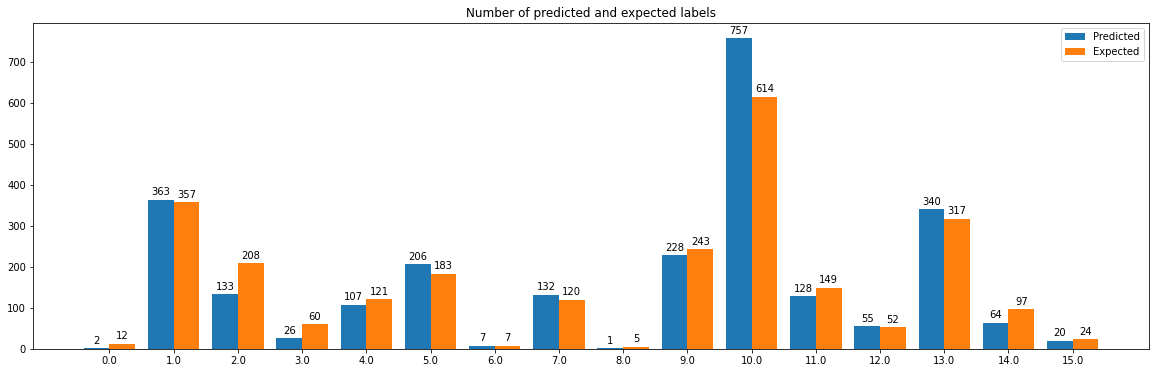

In [32]:
plot_histogram_compare_predict_expect(preds_indiana_test, y_test_indiana_labels)

If we only look at the histogram, we can think that our model is very efficient even if it tends to classify the samples in class 10. 

We will display a confusion matrix.
A confusion matrix is used to highlight false positives and false negatives. The diagonal corresponds to the true positive which makes it possible to visualize more easily the classes having fairly large prediction errors.

By the way, we decided to display this matrix using coloring. This can be done using a linear or logarithmic scale. The logarithmic scale makes it possible to highlight the different variations. 

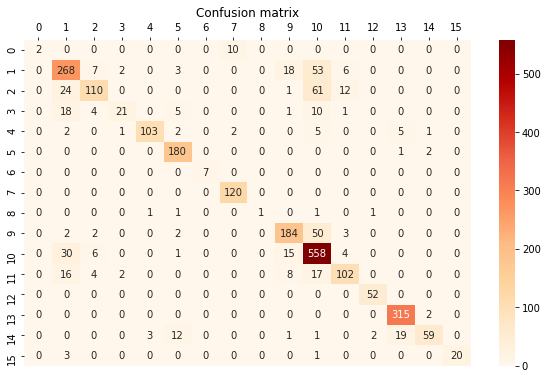

In [33]:
plot_confusion_matrix(y_test_indiana_labels, preds_indiana_test, class_names=indiana_class_names, log=False)

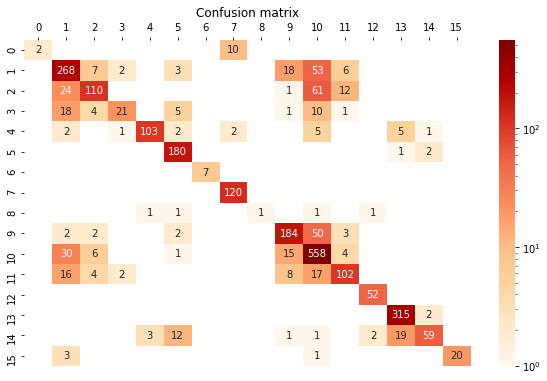

In [34]:
plot_confusion_matrix(y_test_indiana_labels, preds_indiana_test, class_names=indiana_class_names, log=True)

On the confusion matrix, we can see that the model performed well on all classes. There are still some misclassifications on labels 1 and 10.

In [35]:
print(classification_report(y_test_indiana_labels, preds_indiana_test, target_names=indiana_class_names))

              precision    recall  f1-score   support

           0       1.00      0.17      0.29        12
           1       0.74      0.75      0.74       357
           2       0.83      0.53      0.65       208
           3       0.81      0.35      0.49        60
           4       0.96      0.85      0.90       121
           5       0.87      0.98      0.93       183
           6       1.00      1.00      1.00         7
           7       0.91      1.00      0.95       120
           8       1.00      0.20      0.33         5
           9       0.81      0.76      0.78       243
          10       0.74      0.91      0.81       614
          11       0.80      0.68      0.74       149
          12       0.95      1.00      0.97        52
          13       0.93      0.99      0.96       317
          14       0.92      0.61      0.73        97
          15       1.00      0.83      0.91        24

    accuracy                           0.82      2569
   macro avg       0.89   

F1-score stands for:
\begin{equation}
    \frac{TP}{TP + 0.5 * (FP + FN))}
\end{equation}
    
Recall stands for:

\begin{equation}
    \frac{TP}{TP + FN}
\end{equation}

So here we can see that class 0, has been correctly detected (1.0 accuracy) but there are a low f1-score and recall. This means that there are a huge number of False Negatives

#### Classification report for Salinas Model

In [36]:
preds_salinas_test = modelRF_salinas.predict(x_test_salinas)

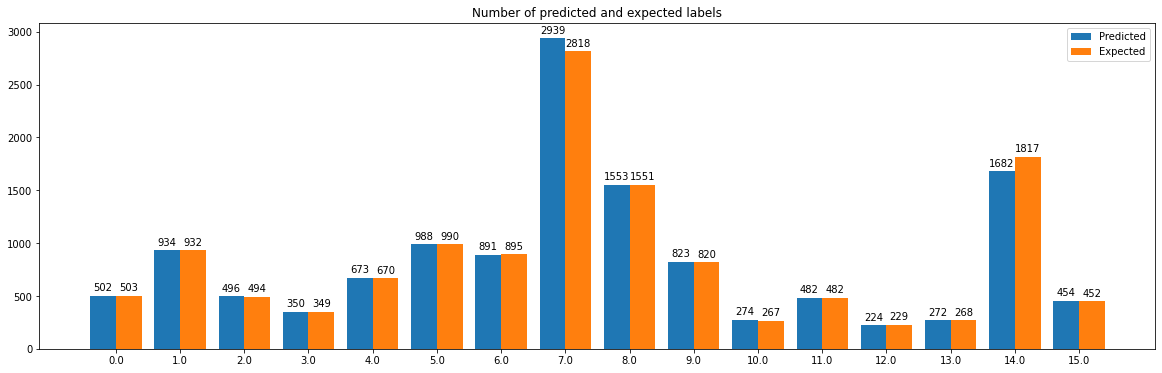

In [37]:
plot_histogram_compare_predict_expect(preds_salinas_test, y_test_salinas_labels)

This histogram seems better than Indiana's one because every class contains at least 200 samples. We can also notice that the model tends to classify samples to label 7.

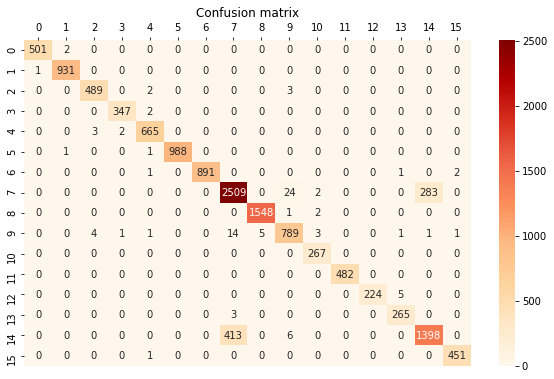

In [38]:
plot_confusion_matrix(y_test_salinas_labels, preds_salinas_test, class_names=salinas_class_names, log=False)

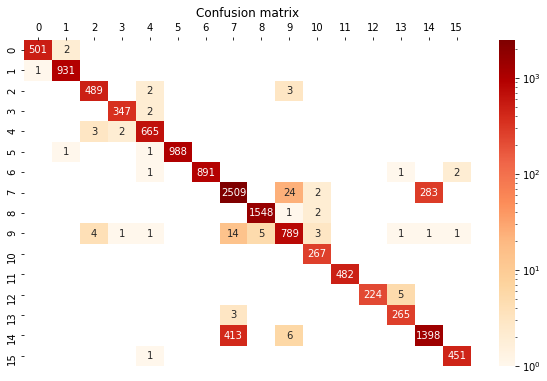

In [39]:
plot_confusion_matrix(y_test_salinas_labels, preds_salinas_test, class_names=salinas_class_names, log=True)

On the confusion matrix we can see that the classification on test data is quite good because there is only a few cells that are off the diagonal.

In [40]:
print(classification_report(y_test_salinas_labels, preds_salinas_test, target_names=salinas_class_names))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       503
           1       1.00      1.00      1.00       932
           2       0.99      0.99      0.99       494
           3       0.99      0.99      0.99       349
           4       0.99      0.99      0.99       670
           5       1.00      1.00      1.00       990
           6       1.00      1.00      1.00       895
           7       0.85      0.89      0.87      2818
           8       1.00      1.00      1.00      1551
           9       0.96      0.96      0.96       820
          10       0.97      1.00      0.99       267
          11       1.00      1.00      1.00       482
          12       1.00      0.98      0.99       229
          13       0.97      0.99      0.98       268
          14       0.83      0.77      0.80      1817
          15       0.99      1.00      1.00       452

    accuracy                           0.94     13537
   macro avg       0.97   

In general, random forest classifier works well on salinas image. We obtained an accuracy of 0.94

### Prediction on images

#### Indiana image

In [41]:
%%time
total_preds_indiana = modelRF_indiana.predict(X_indiana_reduced)

CPU times: user 604 ms, sys: 5.04 ms, total: 609 ms
Wall time: 131 ms


In [42]:
indiana_preds_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))
indiana_preds_img[X_indiana_idx] = total_preds_indiana + 1
indiana_preds_img = indiana_preds_img.reshape(((indiana_img.shape[0], indiana_img.shape[1])))

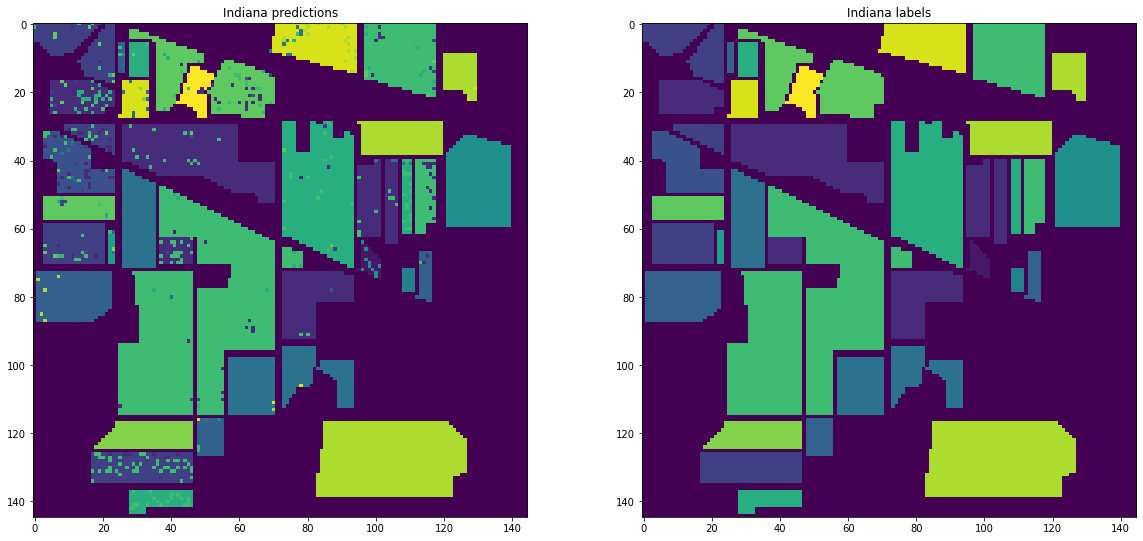

In [43]:
plot_two_figures(indiana_preds_img, indiana_labels, 'Indiana predictions', 'Indiana labels', figsize=(20, 20))

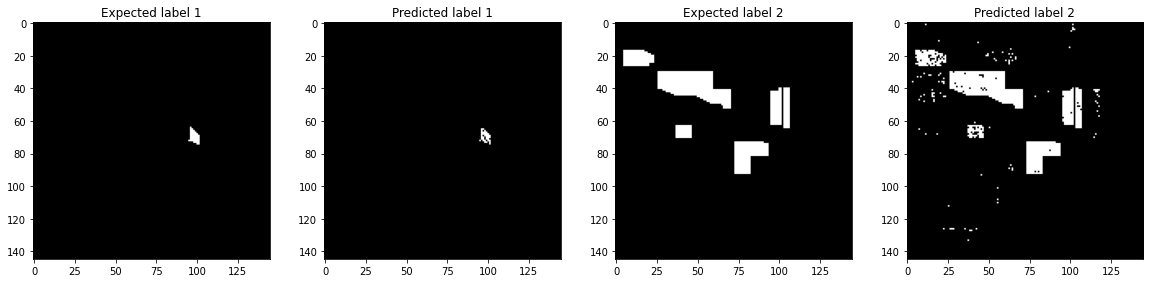

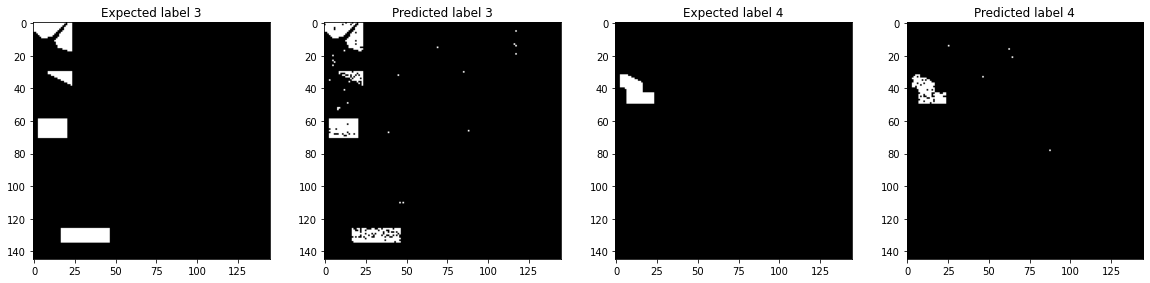

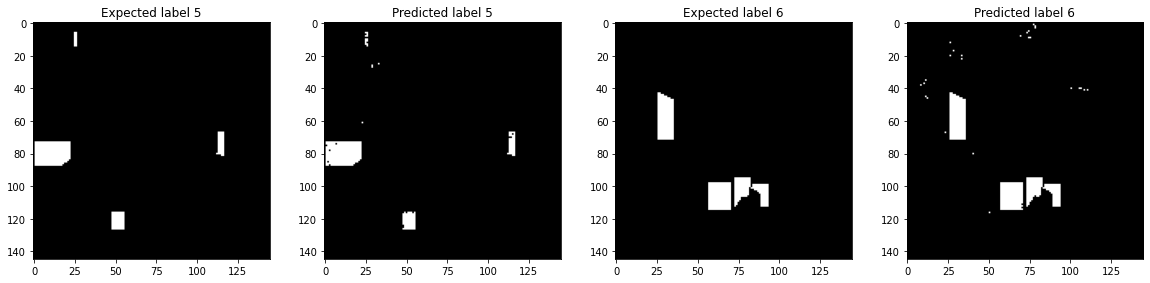

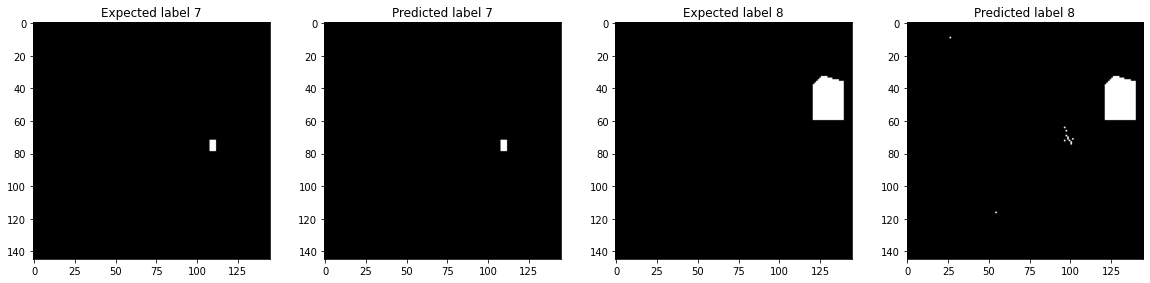

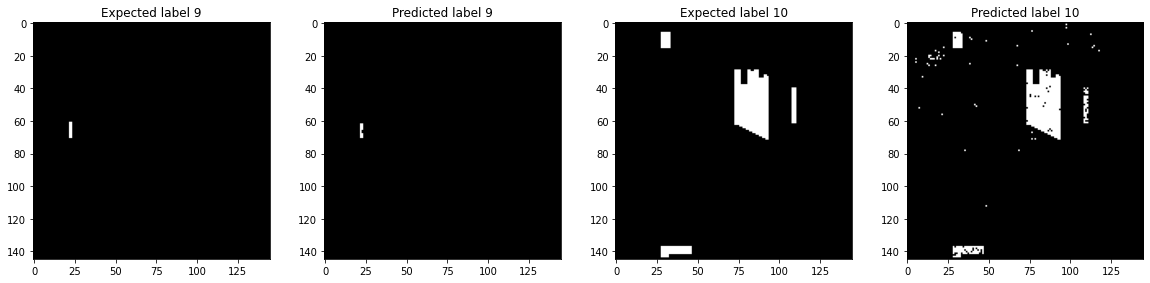

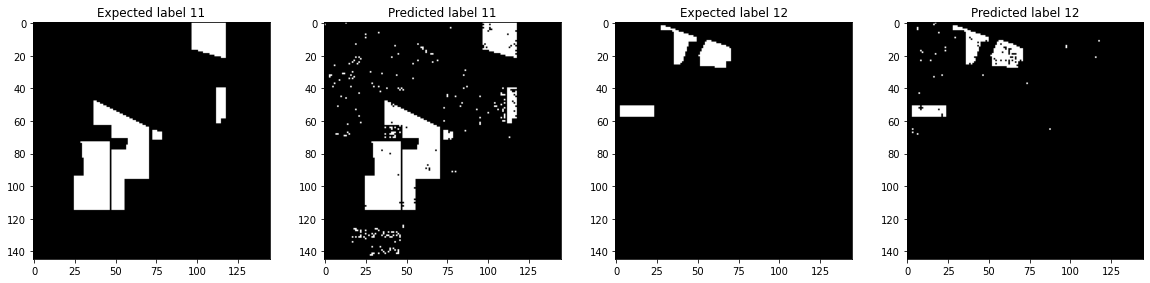

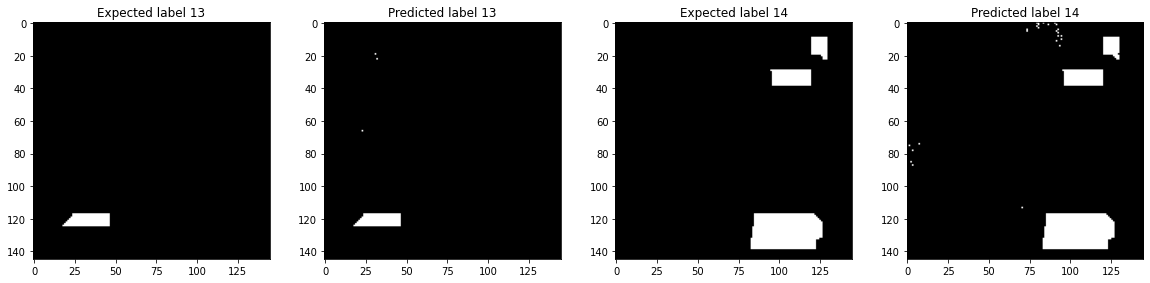

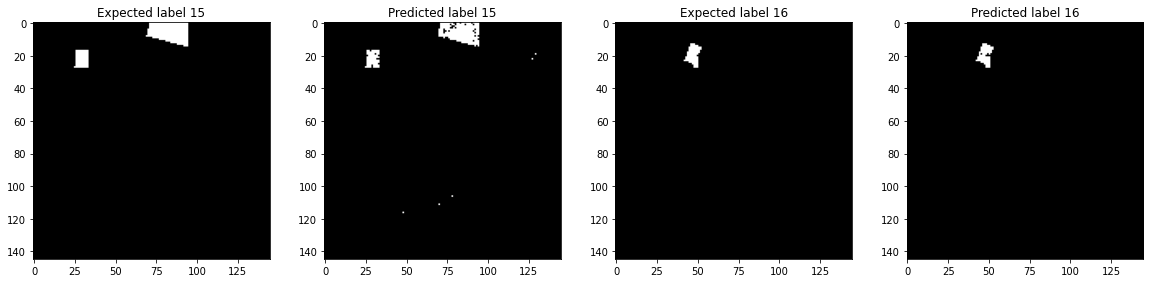

In [44]:
plot_each_labels(indiana_labels, indiana_preds_img, n_classes_indiana, figsize=(20, 20), cmap='gray')

As we can see, the classification works well. We can clearly recognized the same pattern for each label, there is still little noise.

#### Salinas image

In [45]:
%%time
total_preds_salinas = modelRF_salinas.predict(X_salinas_reduced)

CPU times: user 4.31 s, sys: 68.5 ms, total: 4.38 s
Wall time: 867 ms


In [46]:
salinas_preds_img = np.zeros((salinas_img.shape[0] * salinas_img.shape[1]))
salinas_preds_img[X_salinas_idx] = total_preds_salinas + 1
salinas_preds_img = salinas_preds_img.reshape(((salinas_img.shape[0], salinas_img.shape[1])))

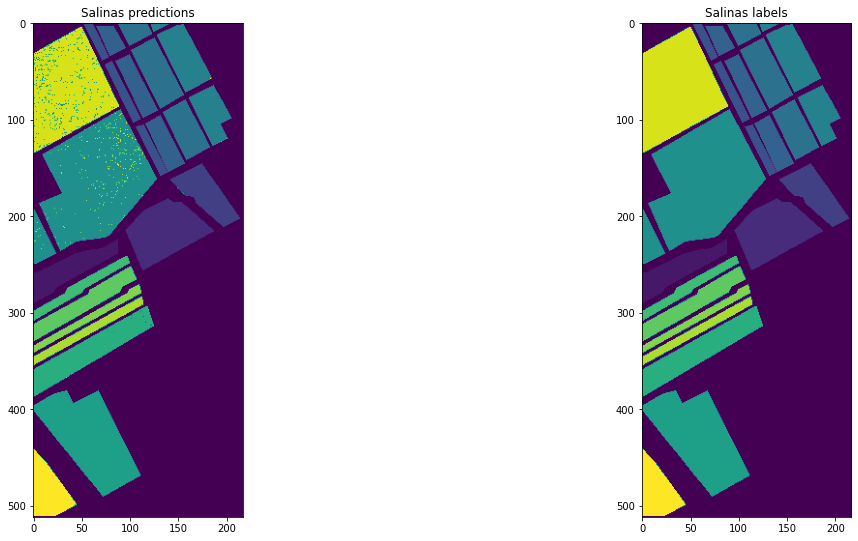

In [47]:
plot_two_figures(salinas_preds_img, salinas_labels, 'Salinas predictions', 'Salinas labels', figsize=(20, 20))

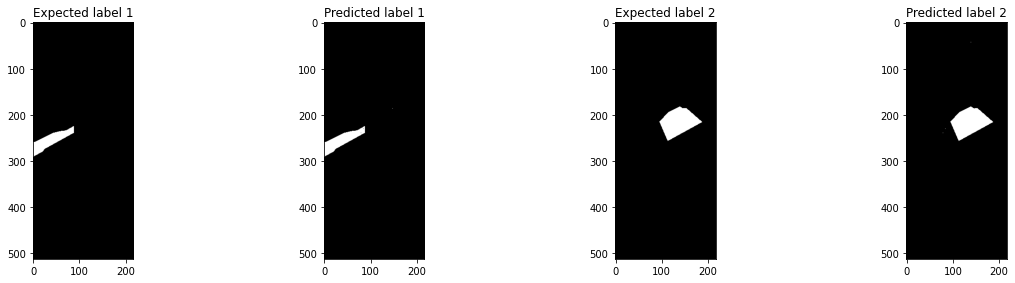

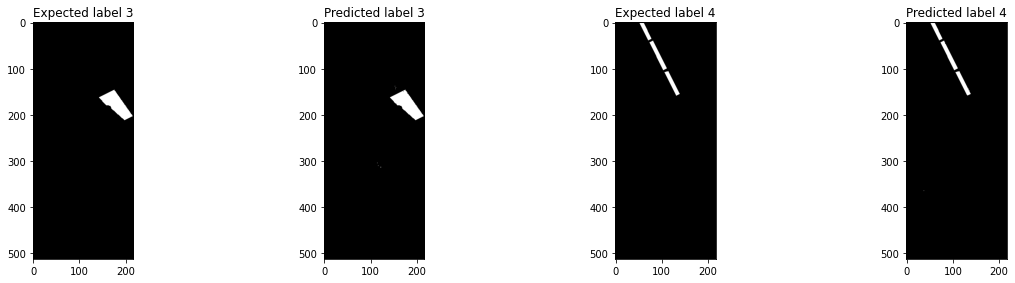

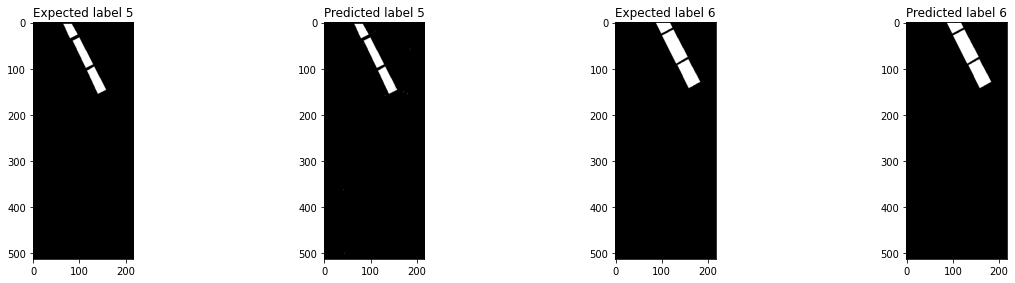

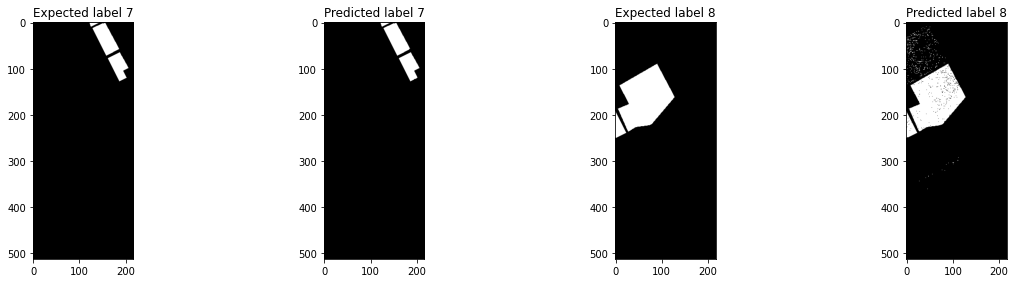

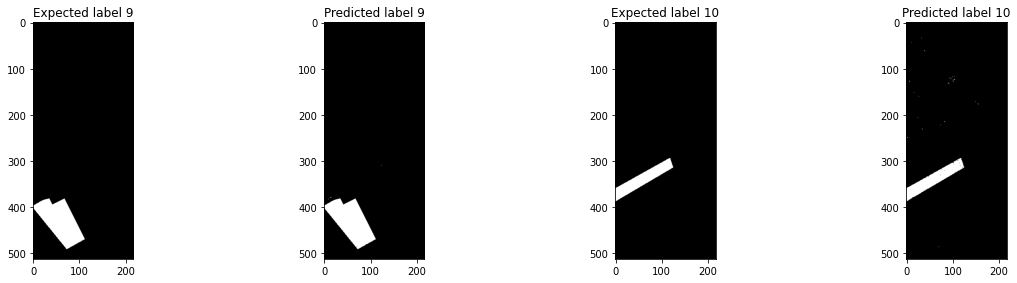

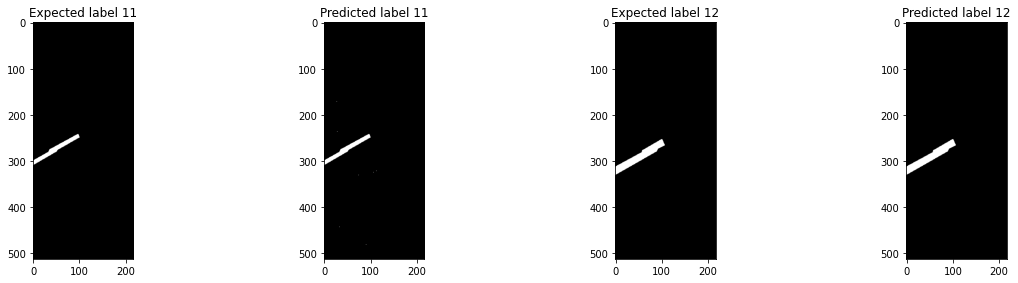

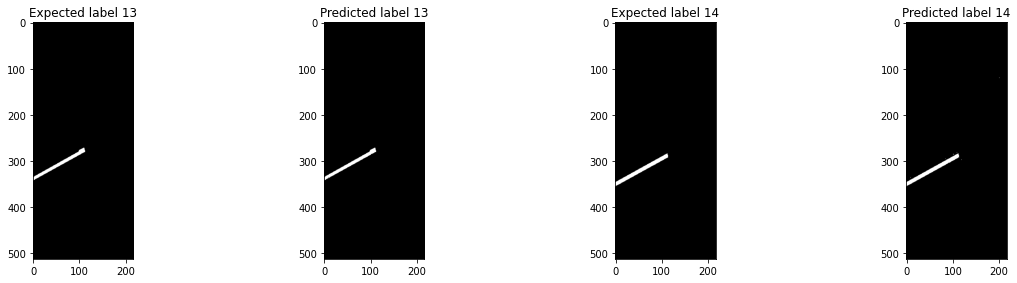

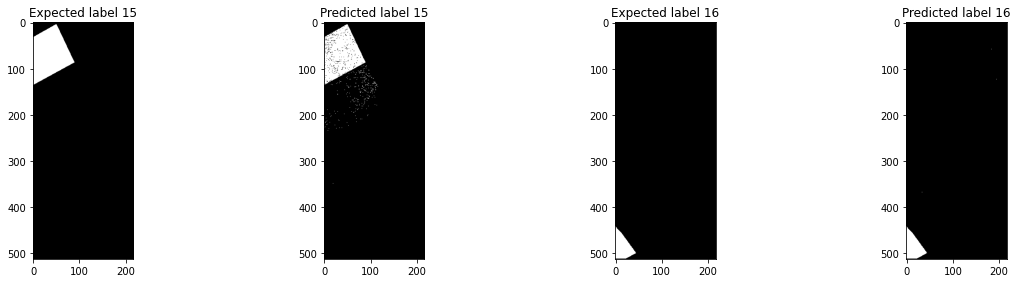

In [48]:
plot_each_labels(salinas_labels, salinas_preds_img, n_classes_salinas, figsize=(20, 20), cmap='gray')

For Salinas image, this model also works well. It seems that there is a little less noise.

## Save predictions

In order to be able to compare models , we save our prediction data on each image. We also save model's score.

In [49]:
np.save('../data/predictions/indiana_preds_randomForest.npy', indiana_preds_img)
np.save('../data/predictions/salinas_preds_randomForest.npy', salinas_preds_img)

In [50]:
# Check if csv file exists
try:
    df = pd.read_csv('../data/score.csv')
except Exception:
    cols = ['model', 'image', 'test_score', 'train_score', 'mean_test_score', 'mean_train_score']
    df = pd.DataFrame(columns=cols)

In [51]:
df.loc[df.shape[0]] = ['RandomForest', 'indiana', indiana_test_score, indiana_train_score, indiana_test_mean_score, indiana_train_mean_score]
df.loc[df.shape[0]] = ['RandomForest', 'salinas', salinas_test_score, salinas_train_score, salinas_test_mean_score, salinas_train_mean_score]

In [52]:
df.to_csv('../data/score.csv', index=False)